## Ref **[link](https://github.com/machrisaa/tensorflow-vgg/blob/master/vgg19.py)**
This is a practice of using VGG-19 model to predict images
[vgg-19.npy](https://dl.dropboxusercontent.com/u/50333326/vgg19.npy)

In [1]:
import os
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

vgg19_npy_path='../vgg19.npy'
data_dict = np.load(vgg19_npy_path, encoding='latin1').item()
print("npy file loaded")

npy file loaded


### load variable from npy to build the VGG
rgb image [batch, height, width, 3] values scaled [0, 1]

In [2]:
# VGG-19 architecture
VGG_MEAN = [103.939, 116.779, 123.68]
def VGG19(rgb):
    start_time = time.time()
    print("build model started")
    # Convert RGB to BGR
    red, green, blue = tf.split(3, 3, rgb)
    assert red.get_shape().as_list()[1:] == [224, 224, 1]
    assert green.get_shape().as_list()[1:] == [224, 224, 1]
    assert blue.get_shape().as_list()[1:] == [224, 224, 1]
    bgr = tf.concat(3, [
        blue - VGG_MEAN[0],
        green - VGG_MEAN[1],
        red - VGG_MEAN[2],
    ])
    assert bgr.get_shape().as_list()[1:] == [224, 224, 3]
    
    conv1_1 = conv_layer(bgr, "conv1_1")
    conv1_2 = conv_layer(conv1_1, "conv1_2")
    pool1 = max_pool(conv1_2, 'pool1')
    
    conv2_1 = conv_layer(pool1, "conv2_1")
    conv2_2 = conv_layer(conv2_1, "conv2_2")
    pool2 = max_pool(conv2_2, 'pool2')
    
    conv3_1 = conv_layer(pool2, "conv3_1")
    conv3_2 = conv_layer(conv3_1, "conv3_2")
    conv3_3 = conv_layer(conv3_2, "conv3_3")
    conv3_4 = conv_layer(conv3_3, "conv3_4")
    pool3 = max_pool(conv3_4, 'pool3')
    
    conv4_1 = conv_layer(pool3, "conv4_1")
    conv4_2 = conv_layer(conv4_1, "conv4_2")
    conv4_3 = conv_layer(conv4_2, "conv4_3")
    conv4_4 = conv_layer(conv4_3, "conv4_4")
    pool4 = max_pool(conv4_4, 'pool4')
    
    conv5_1 = conv_layer(pool4, "conv5_1")
    conv5_2 = conv_layer(conv5_1, "conv5_2")
    conv5_3 = conv_layer(conv5_2, "conv5_3")
    conv5_4 = conv_layer(conv5_3, "conv5_4")
    pool5 = max_pool(conv5_4, 'pool5')
    
    fc6 = fc_layer(pool5, "fc6")
    assert fc6.get_shape().as_list()[1:] == [4096]
    relu6 = tf.nn.relu(fc6)
    
    fc7 = fc_layer(relu6, "fc7")
    relu7 = tf.nn.relu(fc7)
    
    fc8 = fc_layer(relu7, "fc8")
    
    prob = tf.nn.softmax(fc8, name="prob")
    data_dict = None
    print("build model finished: %ds" % (time.time() - start_time))
    return prob
    
def avg_pool(bottom, name):
    return tf.nn.avg_pool(bottom, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

def max_pool(bottom, name):
    return tf.nn.max_pool(bottom, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name=name)

def conv_layer(bottom, name):
    with tf.variable_scope(name):
        filt = get_conv_filter(name)

        conv = tf.nn.conv2d(bottom, filt, [1, 1, 1, 1], padding='SAME')

        conv_biases = get_bias(name)
        bias = tf.nn.bias_add(conv, conv_biases)

        relu = tf.nn.relu(bias)
        return relu
    
def fc_layer(bottom, name):
    with tf.variable_scope(name):
        shape = bottom.get_shape().as_list()
        dim = 1
        for d in shape[1:]:
            dim *= d
        x = tf.reshape(bottom, [-1, dim])

        weights = get_fc_weight(name)
        biases = get_bias(name)

        # Fully connected layer. Note that the '+' operation automatically
        # broadcasts the biases.
        fc = tf.nn.bias_add(tf.matmul(x, weights), biases)

        return fc
    
def get_conv_filter(name):
    return tf.constant(data_dict[name][0], name="filter")

def get_bias(name):
    return tf.constant(data_dict[name][1], name="biases")

def get_fc_weight(name):
    return tf.constant(data_dict[name][0], name="weights")

### test the images

In [3]:
img1 = plt.imread("./test_data/crampfish.jpg")
img2 = plt.imread("./test_data/vulture.jpg")
batch1 = cv2.resize(img1, (224, 224), interpolation=cv2.INTER_AREA)
batch2 = cv2.resize(img2, (224, 224), interpolation=cv2.INTER_AREA)
batch1 = batch1.reshape((1, 224, 224, 3))
batch2 = batch2.reshape((1, 224, 224, 3))
print(type(batch1[0][0][0][1]))

batch = np.concatenate((batch1, batch2), 0)
print(batch.shape)

images = tf.placeholder("float", [2, 224, 224, 3])
probs = VGG19(images)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    out = sess.run(tf.nn.top_k(probs,k=5), feed_dict={images: batch})
print(out)

<class 'numpy.uint8'>
(2, 224, 224, 3)
build model started
build model finished: 0s
TopKV2(values=array([[  5.07201433e-01,   2.24314988e-01,   1.80595905e-01,
          6.85912073e-02,   1.92675311e-02],
       [  9.99264181e-01,   3.80237063e-04,   2.10315935e-04,
          5.00050337e-05,   4.92556028e-05]], dtype=float32), indices=array([[  6,   5,   3,   4,   2],
       [ 23,  21,  93, 128,  22]]))


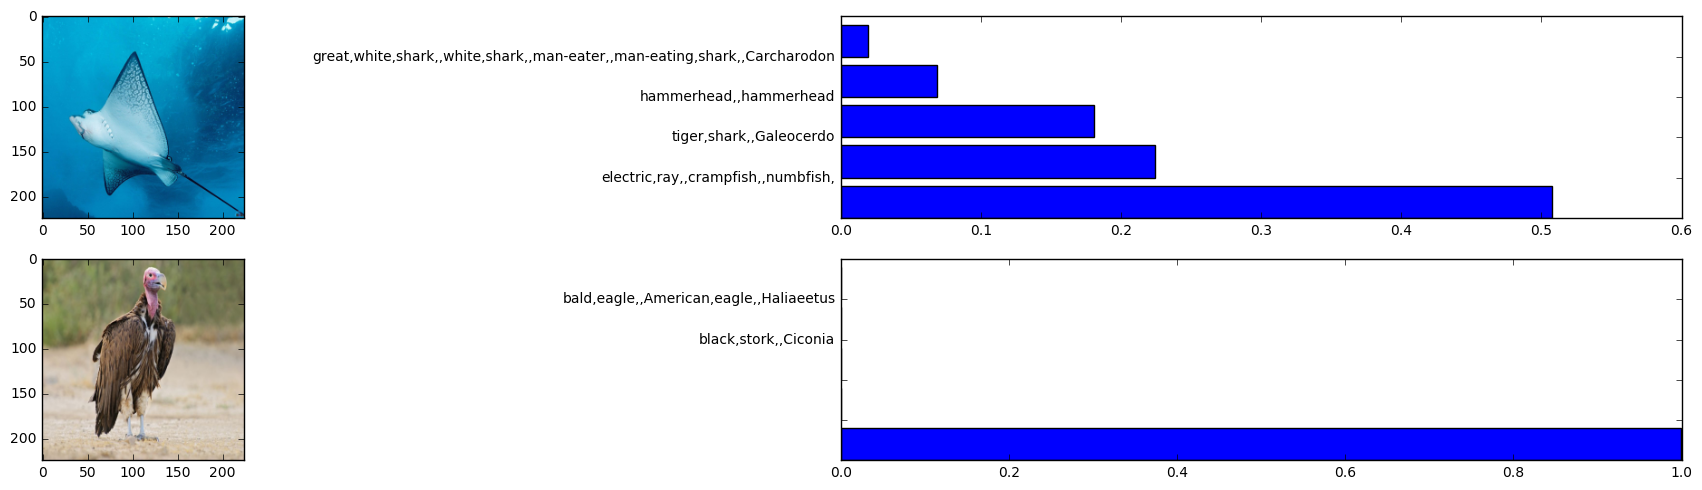

In [33]:
synset = np.array([l.strip() for l in open('synset.txt').readlines()])
plt.figure(figsize=(20,5))
for (i,top5_v,top5_idx) in zip(range(2),out[0],out[1]):
    plt.subplot(2,2,i*2+1)
    plt.imshow(batch[i])
    plt.subplot(2,2,(i+1)*2)
    obj_name = [",".join(name.split()[1:-1]) for name in synset[top5_idx]]
    plt.barh(range(1,6),top5_v)
    plt.yticks(range(1,6),obj_name)
plt.tight_layout()